In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

#Be careful for set path
cur_path1 = os.getcwd()


In [45]:
print(cur_path1)
#q_star_arr = [ "1700", "1800", "1900", "2000", "2100", "2200", "2300", "2400"]
q_star_arr = [ "100", "200", "300", "400", "500", "600", "700", "800", "900", "1000", "1100", "1200", "1300", "1400", "1500", "1550", "1600", "1700"]
#q_star_arr = [ "100", "200", "300", "400", "500", "600", "700", "800", "900", "1000", "1100", "1200", "1300", "1400", "1500", "1550", "1600", "1700", "1800", "1900", "2000", "2100", "2200", "2300", "2400"]
# q_star_arr = [ "100", "200", "300", "400", "500", "600", "700", "800", "900", "1000", "1100", "1200", "1300", "1400", "1500", "1600", "1700", "1800" , "1900" ]
cur_path = cur_path1

C:\Users\jeong\Desktop\tutorial\AFPs\Tm\wham


In [46]:
#Get q values for each simulation and save it as numpy array. Data is a list collecting all numpy arrays.
q_arr = []

for i in q_star_arr:
    work_path = cur_path + "\\" +i
    print(work_path)
    os.chdir(work_path)
    
    file = 'TM_'+i+'_monitor.dat'
    q = np.array(pd.read_csv(file, sep='\t|  ',engine='python'))
    print(q.shape)
    
    if np.int(i) < 200:
        q_arr += [q[75000:,1]]
    else:
        q_arr += [q[25000:,1]]

q_arr = np.array(q_arr)

C:\Users\jeong\Desktop\tutorial\AFPs\Tm\wham\100
(100001, 7)
C:\Users\jeong\Desktop\tutorial\AFPs\Tm\wham\200
(50001, 7)
C:\Users\jeong\Desktop\tutorial\AFPs\Tm\wham\300
(50001, 7)
C:\Users\jeong\Desktop\tutorial\AFPs\Tm\wham\400
(50001, 7)
C:\Users\jeong\Desktop\tutorial\AFPs\Tm\wham\500
(50001, 7)
C:\Users\jeong\Desktop\tutorial\AFPs\Tm\wham\600
(50001, 7)
C:\Users\jeong\Desktop\tutorial\AFPs\Tm\wham\700
(50001, 7)
C:\Users\jeong\Desktop\tutorial\AFPs\Tm\wham\800
(50001, 7)
C:\Users\jeong\Desktop\tutorial\AFPs\Tm\wham\900
(50001, 7)
C:\Users\jeong\Desktop\tutorial\AFPs\Tm\wham\1000
(50001, 7)
C:\Users\jeong\Desktop\tutorial\AFPs\Tm\wham\1100
(50001, 7)
C:\Users\jeong\Desktop\tutorial\AFPs\Tm\wham\1200
(50001, 7)
C:\Users\jeong\Desktop\tutorial\AFPs\Tm\wham\1300
(50001, 7)
C:\Users\jeong\Desktop\tutorial\AFPs\Tm\wham\1400
(50001, 7)
C:\Users\jeong\Desktop\tutorial\AFPs\Tm\wham\1500
(50001, 7)
C:\Users\jeong\Desktop\tutorial\AFPs\Tm\wham\1550
(50001, 7)
C:\Users\jeong\Desktop\tutorial\

In [47]:
q_star_arr2 = np.array([np.int(q_star_arr[i]) for i in range(len(q_star_arr))])

In [72]:
# This code is writting by Jeongmoon Choi
# email: jeongmoon2006@gmail.com

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import autograd.numpy as nup
from autograd import value_and_grad
from scipy.optimize import minimize


class binwham:
    
    '''
    Calculates free energy using bin wham.
    Code is based on Zhu, Fangqiang, and Gerhard Hummer. Journal of computational chemistry 33.4 (2012): 453-465.
    
    Pil = fi*Cil*Pl
    
    Args:
      op_star_arr(numpy.ndarray): op* matrix (N,)
      op_arr(numpy.ndarray): op matrix (simulation #, time #)
      n_bins(int): The number of bins that the probability should bin
      kappa(float): harmonic bias spring constant in kJ/mol
    '''
    
    def __init__(self, op_star_arr, op_arr, kappa, n_bins=100, T=298):
        
        self.op_star_arr = op_star_arr
        self.op_arr = op_arr
        self.n_bins = n_bins
        self.kappa = kappa
        self.T = T
        self.beta = 1/8.314/T*1000
        self.M = n_bins
        
        
        #S: number of simulations
        self.S = len(self.op_star_arr)
        
        #M: number of bins
        self.M = n_bins
        
        #Ni: number of samples in each simulation
        self.Ni = np.array([len(self.op_arr[i]) for i in range(self.S)])
        
        #Ml: number of simulations in the bin - np.ndarray(n_bins,)
        min_ = np.min(self.op_arr)
        max_ = np.max(self.op_arr)

        self.bins_1 = np.linspace(min_, max_, self.M+1) #shape (M+1,)
        self.bins_ = self.bins_1[1:] #shape (M,)
        
        digitized = np.digitize(self.op_arr, self.bins_1, right = False)
        self.Ml = np.array([(digitized == i).sum() for i in range(1, self.M +1)])
        
        #Pil: probability for each simulation on each bins - np.ndarray(S,M)
        self.Pil = np.zeros((self.S, self.M))
        for i in range(self.S):
            digitized = np.digitize(self.op_arr[i], self.bins_1, right = False)
            count = np.array([(digitized == i).sum() for i in range(1, self.M+1)])
            self.Pil[i,:] = count/len(digitized)
            
        #Wil: bias potential energy - kappa/2*(xl-ri)^2 np.ndarray((S,M))
        self.Wil = np.zeros((self.S,self.M))
        for i in range(self.S):

            ri = self.op_star_arr[i]
            self.Wil[i,0] = self.kappa/2*np.power(self.bins_[0] - ri,2)

            for l in range(1,self.M):
                middle = (self.bins_[l] + self.bins_[l-1])/2
                self.Wil[i,l] = self.kappa/2*np.power(middle-ri,2)


        self.Cil = np.exp(-self.Wil*self.beta)

        self.gi0 = np.zeros(self.S,) - 1e-8
        

    def optimize_fn(self, gi, Ni, Ml, Cil):
        
        first_term = - (Ni*gi).sum()
        log_pl = nup.log(Ml) - nup.log(nup.array([Ni[i]*Cil[i,:]*nup.exp(gi[i]) for i in range(self.S)]).sum(axis = 0))
        second_term = - (Ml*log_pl).sum()

        return first_term + second_term
    
    def MLE_optimize(self):
        
        ftol=2.22e-09
        gtol=1e-05
        maxiter=15000
        maxfun=15000
        iprint=-1
        result = minimize(value_and_grad(self.optimize_fn),self.gi0,args=(self.Ni,self.Ml,self.Cil),jac=True,method='L-BFGS-B', options={'ftol':ftol,'gtol':gtol,'maxiter':maxiter,'maxfun':maxfun,'iprint':iprint})

        if result.success:
            gi = result.x
            log_pl = np.log(self.Ml) - np.log(np.array([self.Ni[i]*self.Cil[i,:]*nup.exp(gi[i]) for i in range(self.S)]).sum(axis = 0))
            F = -log_pl
            F = F - np.min(F)
            
            plt.plot(self.bins_,F)
            
            return gi, log_pl, F
        
        else:
            print('fail to do minimization')
        
        

In [77]:
cc = binwham(q_star_arr2, q_arr, 0.01, 40)

In [78]:
cc.gi0.shape

(18,)

In [79]:
a = cc.Ml
print(a.shape)
print(a)

(40,)
[29420 28512 18077 22175  2458 13461 10558   431  9671 14870  3094 19312
  2984  7137 17059   986 12446 12245   565 17701  6837  1398 18265  5351
  7258 17138  1747 19058  4796  6352 17732  2254 17266  8371 19833 20538
  7636   589 20129  4307]


In [80]:
gi, log_pl, F = cc.MLE_optimize()

fail to do minimization


TypeError: cannot unpack non-iterable NoneType object

In [6]:
#initialize

#T: Temperature
temperature = 298
T = temperature
beta = 1/8.314/T*1000

#kappa: spring constant in kJ/mol
kappa = 0.01

# S: number of windows (simulations)
S = len(q_arr)

# bins: number of bins (setting value)
bins = 100
M = bins

#Ni: number of samples in each simulation
Ni = np.array([len(q_arr[i]) for i in range(S)])

# Ml: number of simulations in the bin shape bins
min_ = np.min(q_arr)
max_ = np.max(q_arr)
bins_ = np.linspace(min_, max_, M)

digitized = np.digitize(q_arr, bins_,right = True)
Ml = np.array([(digitized == i).sum() for i in range(M)])

# Pil: probability for each simulation on each bins (S,M)
Pil = np.zeros((S,M))
for i in range(S):
    digitized = np.digitize(q_arr[i], bins_, right = True)
    count = np.array([(digitized == i).sum() for i in range(M)])
    Pil[i,:] = count/len(digitized)

# Wil: bias potential energy kappa/2(xl-ri)^2 (S,M)

Wil = np.zeros((S,M))
for i in range(S):
    
    ri = q_star_arr2[i]
    Wil[i,0] = kappa/2*np.power(bins_[0] - ri,2)
    
    for l in range(1,M):
        middle = (bins_[l] + bins_[l-1])/2
        Wil[i,l] = kappa/2*np.power(middle-ri,2)
        


Cil = np.exp(-Wil*beta)

gi0 = np.zeros(S,) - 1e-8


In [7]:
import autograd.numpy as nup

def optimize_fn(gi,Ni,Ml,Cil):
    first_term = - (Ni*gi).sum()
    log_pl = nup.log(Ml) - nup.log(nup.array([Ni[i]*Cil[i,:]*nup.exp(gi[i]) for i in range(S)]).sum(axis = 0))
    second_term = - (Ml*log_pl).sum()
    
    return first_term + second_term

In [ ]:
def min_grad(gi,)

In [8]:
from autograd import value_and_grad
from scipy.optimize import minimize

ftol=2.22e-09
gtol=1e-05
maxiter=15000
maxfun=15000
iprint=-1
result = minimize(value_and_grad(optimize_fn),gi0,args=(Ni,Ml,Cil),jac=True,method='L-BFGS-B', options={'ftol':ftol,'gtol':gtol,'maxiter':maxiter,'maxfun':maxfun,'iprint':iprint})

In [169]:
n = value_and_grad(optimize_fn)

In [171]:
print(n)

<function unary_to_nary.<locals>.nary_operator.<locals>.nary_f at 0x0000028D2DA8FEE0>


In [9]:
result.success

True

In [10]:
result.x

array([-573.23239564, -538.52190232, -474.98530345, -388.76038053,
       -288.89777918, -194.44877441, -100.44062873,   -4.95582491,
         89.55760803,  182.47684634,  273.76239952,  363.29744658,
        455.89126368,  550.5025019 ,  648.75492297])

In [9]:
gi = result.x

In [10]:
log_pl = np.log(Ml) - np.log(np.array([Ni[i]*Cil[i,:]*nup.exp(gi[i]) for i in range(S)]).sum(axis = 0))

In [11]:
F = -log_pl
F = F - np.min(F)

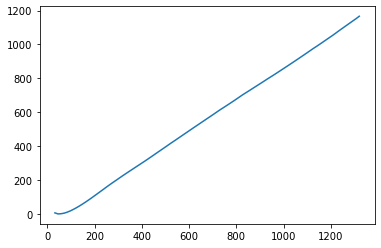

In [45]:
import matplotlib.pyplot as plt
plt.plot(bins_,F)

In [ ]:
---------------------------------------------------------------------------------

In [53]:
# This code is writting by Jeongmoon Choi
# email: jeongmoon2006@gmail.com

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

class sparse_sampling:
    '''
    Calculates free energy using sparse sampling
    
    Energy has three terms. 
    1. first energy: density probability of bias simulation
    2. second energy: applied harmonic potential 
    3. third energy: thermodynamic integration
    
    Args:
      q_star_arr(numpy.ndarray): q* matrix (N,)
      q_arr(numpy.ndarray): q matrix (simulation #, time #)
      n_bins(int): The number of bins that the probability should bin
      kappa(float): harmonic bias spring constant in kJ/mol
    '''
    
    
    def __init__(self, q_star_arr, q_arr, n_bins, kappa):
        
        self.q_star_arr = q_star_arr
        self.q_arr = q_arr
        self.n_bins = n_bins
        self.kappa = kappa
        
        #number of simulations
        self.n_simulation = q_arr.shape[0]
        
        #number of time frames for each simulation
        self.n_time = q_arr.shape[1]
        
        #average q value for each simulation
        self.average_q = []
        for i in range(self.n_simulation):
            self.average_q += [np.average(q_arr[i])]
        self.average_q = np.array(self.average_q)
        
    
    def first_energy(self, plot = True):
        
        '''
        Return:
           1. bins(numpy.ndarray): collection of bins for each simulation (simulation #, n_bins)
           2. prob(numpy.ndarray): collection of probability for each simulation (simulation #, n_bins)
           3. first_energy(numpy.ndarray): first energy for each simulation without unit(simulation #,)
        '''
        
        bins = []
        prob = []
        
        for i in range(self.n_simulation):
            q = self.q_arr[i]
            min_ = np.min(q)
            max_ = np.max(q)
            bins_ = np.linspace(min_, max_, self.n_bins)
            
            digitized = np.digitize(q, bins_, right = True)
            prob_ = (np.array([(digitized == i).sum() for i in range(0,self.n_bins)])+1)/ self.n_time
            
            bins += [bins_]
            prob += [prob_]
            
        bins = np.array(bins)
        prob = np.array(prob)
        
        first_energy = []
        for i in range(self.n_simulation):
            first_energy += [-np.log(np.max(prob[i]))]
        first_energy = np.array(first_energy)
        
        
        #make plot
        if plot:
            figure(figsize=(8, 6), dpi=200)

            for i in range(bins.shape[0]):
                plt.plot(bins[i], -np.log(prob[i]), marker = 'o')

            plt.legend(q_star_arr, bbox_to_anchor=(1.01, 1.05))    
            plt.xlabel(r'$\tilde{q}$', fontsize=15)
            plt.ylabel(r'$\beta F_v^{harm}(\tilde{q})$', fontsize=15)
        
        
        return bins, prob, first_energy
    
    
    
    def second_energy(self,temperature = 298, plot = True):
        
        '''
        Return:
           1. average_q(numpy.ndarray): average q value for each simulation (simulation #,)
           2. second_energy(numpy.ndarray): second energy term without unit (simulation #,)
        '''
        
        second_energy = []
        
        for i in range(self.n_simulation):
            q_diff = self.average_q[i] - np.float(self.q_star_arr[i])
            beta_T = 1/8.314/temperature*1000
            second_energy += [0.5*self.kappa*np.power(q_diff,2)*beta_T]
            
        second_energy = np.array(second_energy)
        
        #plot
        if plot:
            figure(figsize=(8, 6), dpi=200)
            plt.plot(self.average_q, second_energy, marker = 'o')
            plt.xlabel(r'$\tilde{q}$', fontsize=15)
            plt.ylabel(r'$\beta U_{v}^{harm}$', fontsize=15)
        
        return self.average_q, second_energy
    

    
    def third_energy(self,temperature = 298, plot = True):
        
        '''
        Return:
           1. q_star_arr(numpy.ndarray): q star value for each simulation (simulation #,)
           2. third_energy(numpy.ndarray): third energy term without unit (simulation #,)
        '''      
        
        
        #Calculate integrand
        dfdq_star=[]

        for i in range(self.n_simulation):
            q_diff = -(self.average_q[i]-np.float(self.q_star_arr[i]))
            beta_T = 1/8.314/temperature*1000
            dfdq_star+=[0.01*q_diff*beta_T]

        dfdq_star=np.array(dfdq_star)

        #make a plot
        if plot:
            figure(figsize=(8, 6), dpi=200)
            plt.plot(self.q_star_arr, dfdq_star, marker = 'o')
            plt.xlabel(r'$q*$', fontsize=15)
            plt.ylabel(r'$\beta \partial F_{q*}/ \partial q*$', fontsize=15)
        
        
        
        #Get integral
        #make the first term 0. Note that it is integral. I should have reference value, in this case the value would be 0
        third_energy=[]
        third_energy+=[0]
        for i in range(self.n_simulation -1):
            third_energy += [(np.float(self.q_star_arr[i+1]) - np.float(self.q_star_arr[i]))*(dfdq_star[i+1] + dfdq_star[i])/2 + np.float(third_energy[i])]
        third_energy=np.array(third_energy)

        #make a plot
        if plot:
            figure(figsize=(8, 6), dpi=200)
            plt.plot(self.q_star_arr, third_energy, marker = 'o')
            plt.xlabel(r'$q*$', fontsize=15)
            plt.ylabel(r'$\beta F_{harm} (q*)$', fontsize=15)
        
        return self.q_star_arr, third_energy
    
    
    def free_energy(self, temperature = 298, plot = False):
        
        '''
        Return:
           1. q_star_arr(numpy.ndarray): q star value for each simulation (simulation #,)
           2. free_energy(numpy.ndarray): free energy term without unit (simulation #,)
           3. driving_force(numpy.ndarray): driving force term without unit (simulation # -1,)
        '''      
        
        _, _, first = self.first_energy(plot)
        _, second = self.second_energy(temperature, plot)
        _, third = self.third_energy(temperature, plot)
        
        figure(figsize=(8, 6), dpi=200)
        free_energy = first - second + third
        min_e = np.min(free_energy)
        #set starting free energy as 0
        free_energy = free_energy - min_e
        
        figure(figsize=(8, 6), dpi=200)
        plt.plot(self.average_q, free_energy, marker = 'o')
        plt.xlabel(r'$\tilde {q}$', fontsize=15)
        plt.ylabel(r'$\beta F_{v} (\tilde {q})$', fontsize=15)
        
        
        #Get driving force by differentiating the free energy
        diff_average_q = np.array([self.average_q[i+1]- self.average_q[i] for i in range(np.shape(self.average_q)[0]-1)])
        diff_energy = np.array([free_energy[i+1]- free_energy[i] for i in range(np.shape(self.average_q)[0]-1)])
        driving_force = diff_energy/diff_average_q

        figure(figsize=(8, 6), dpi=200)
        plt.plot(self.average_q[:-1], driving_force, marker = 'o')
        plt.xlabel(r'$\tilde {q}$', fontsize=15)
        plt.ylabel(r'$\beta \partial F_{v}/\partial \tilde {q}$', fontsize=15)
        
        
        
        return self.average_q, free_energy, driving_force

In [54]:
aa = sparse_sampling(q_star_arr, q_arr, 50, 0.01)

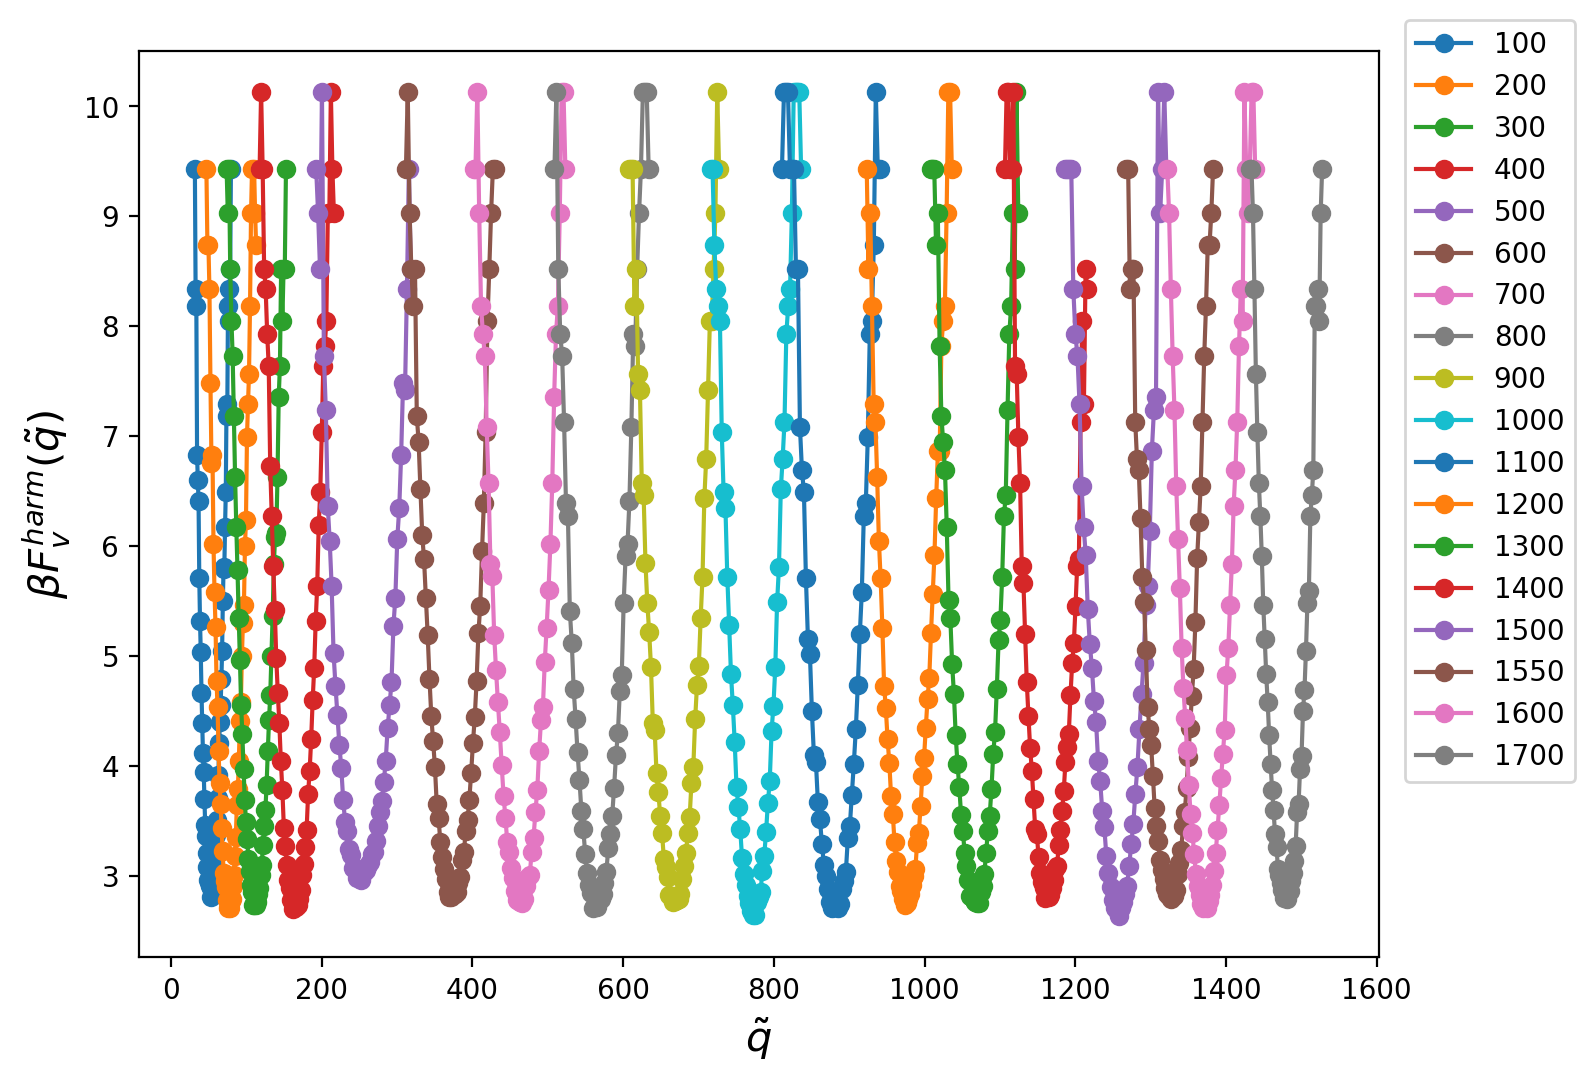

In [55]:
pro, binss, first_e = aa.first_energy()

<Figure size 1600x1200 with 0 Axes>

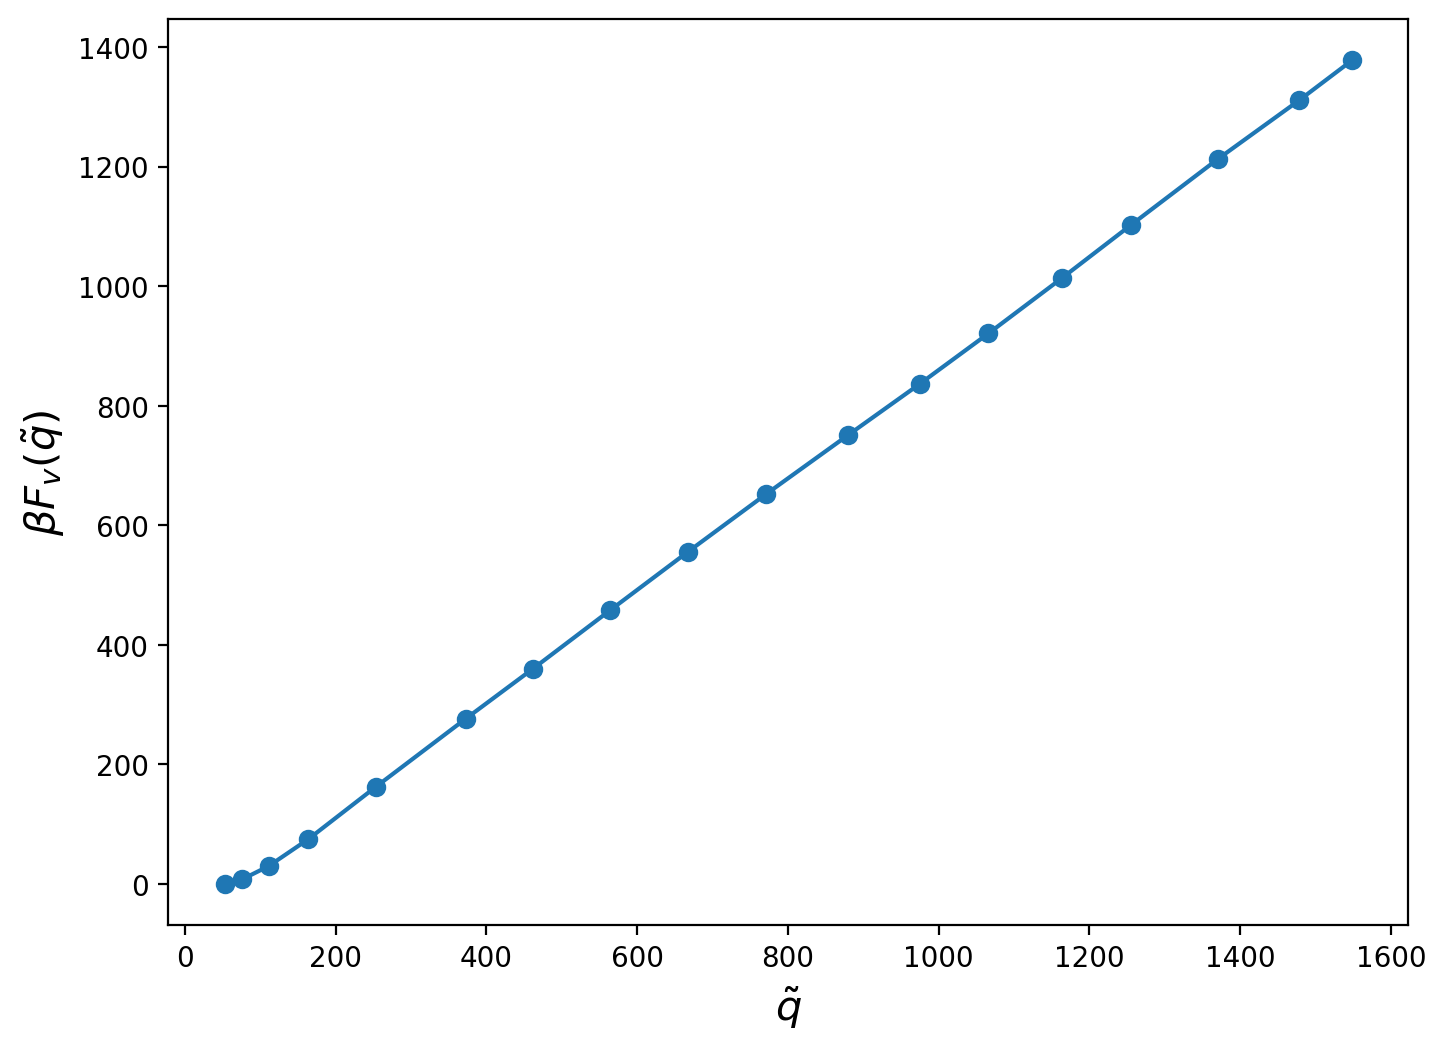

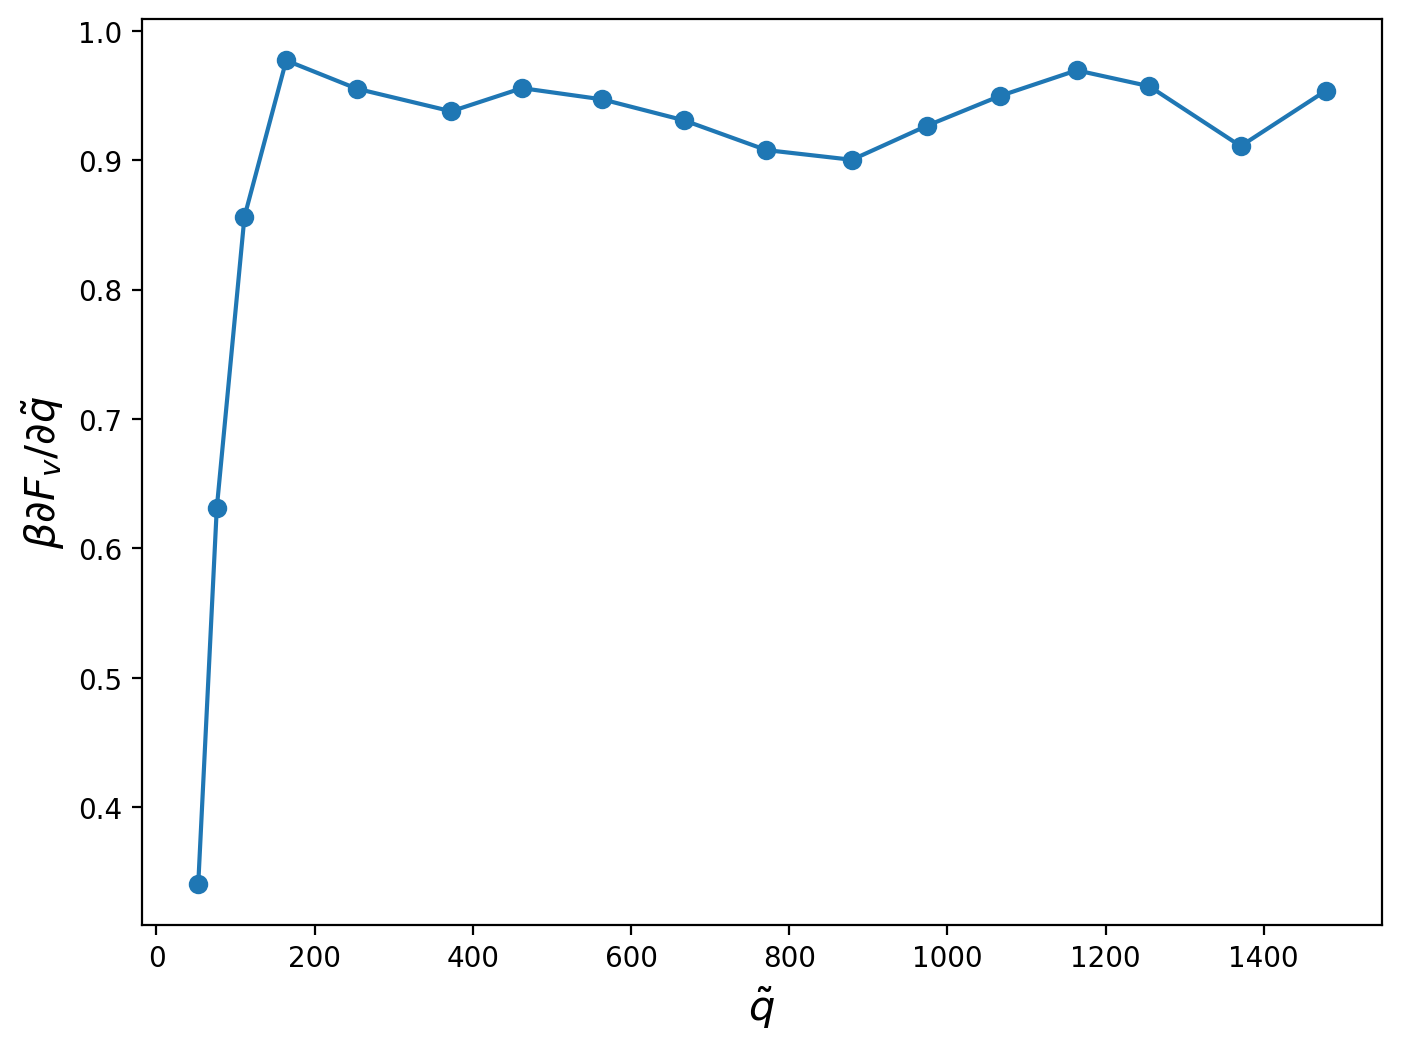

In [11]:
aq, free, driving = aa.free_energy()

Text(0, 0.5, '$\\beta F$')

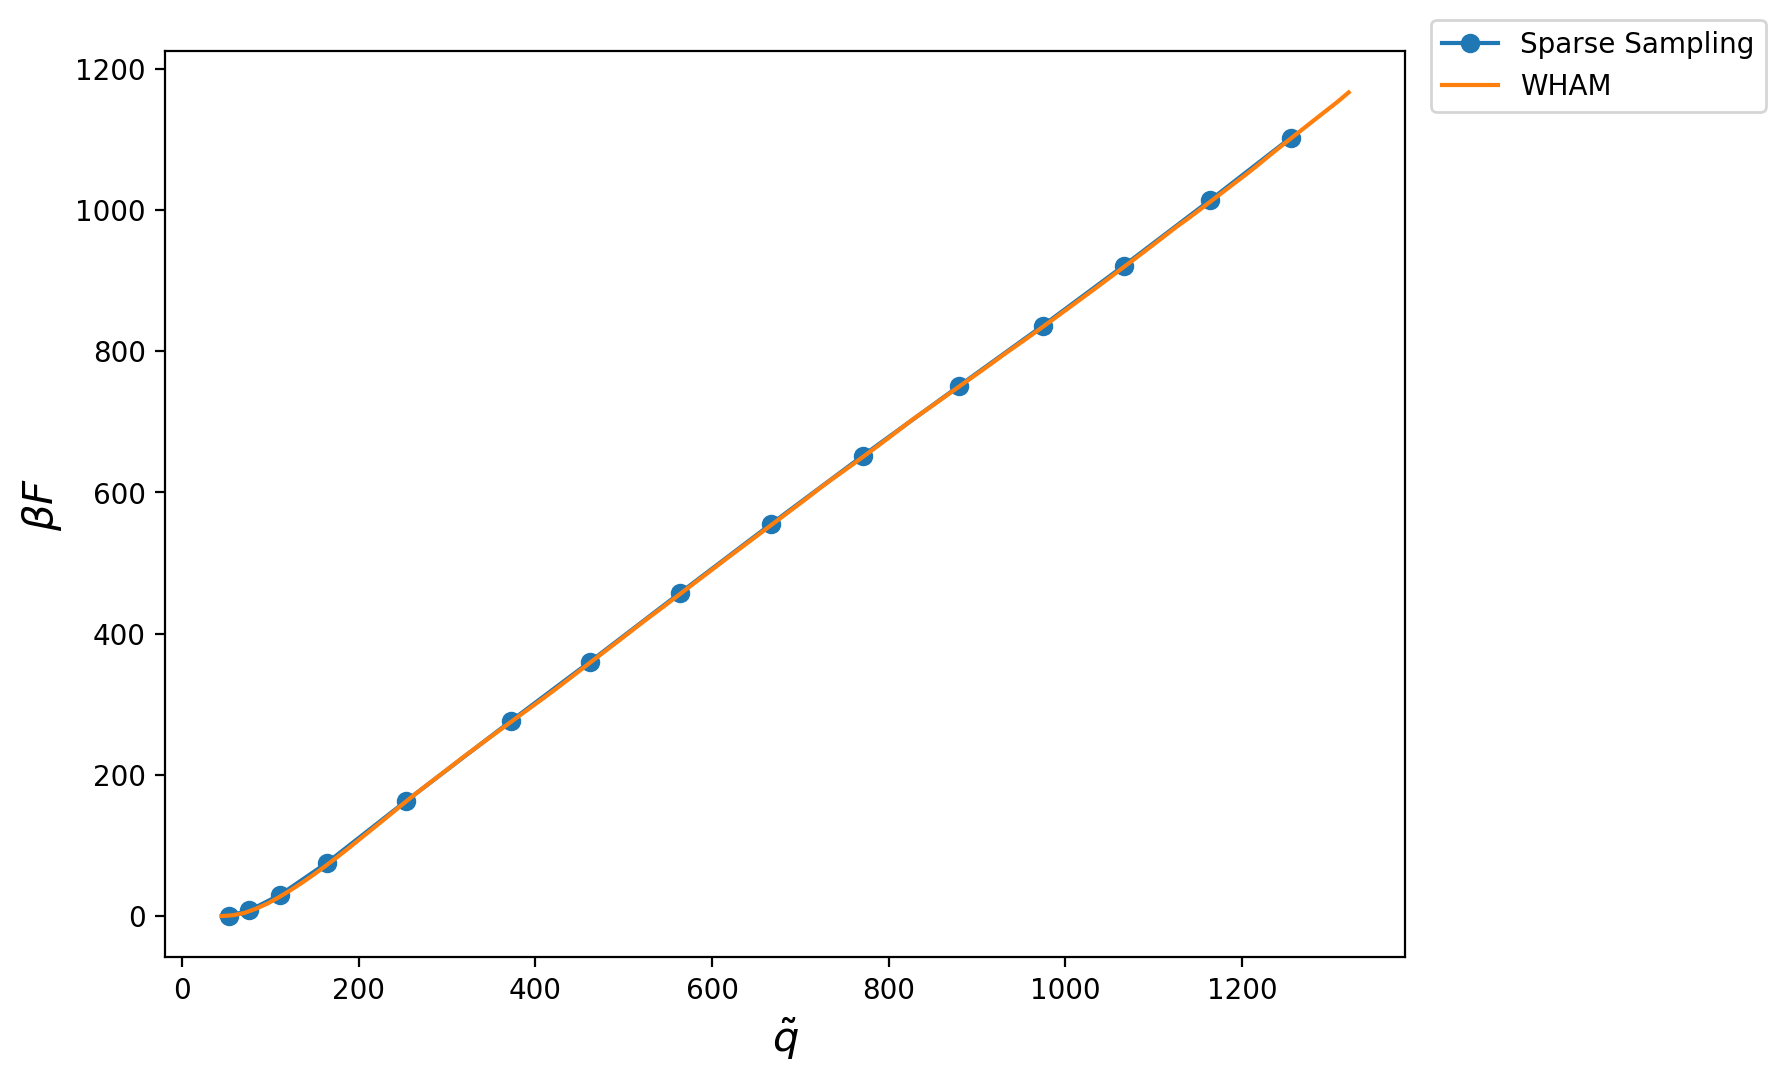

In [19]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=200)

x = 4
plt.plot(aq,free, marker='o')
plt.plot(bins_[1:],F[1:])
plt.legend(['Sparse Sampling', 'WHAM'], bbox_to_anchor=(1.01, 1.05))  
plt.xlabel(r'$\tilde{q}$', fontsize=15)
plt.ylabel(r'$\beta F$', fontsize=15)

Text(0, 0.5, '$\\beta F$')

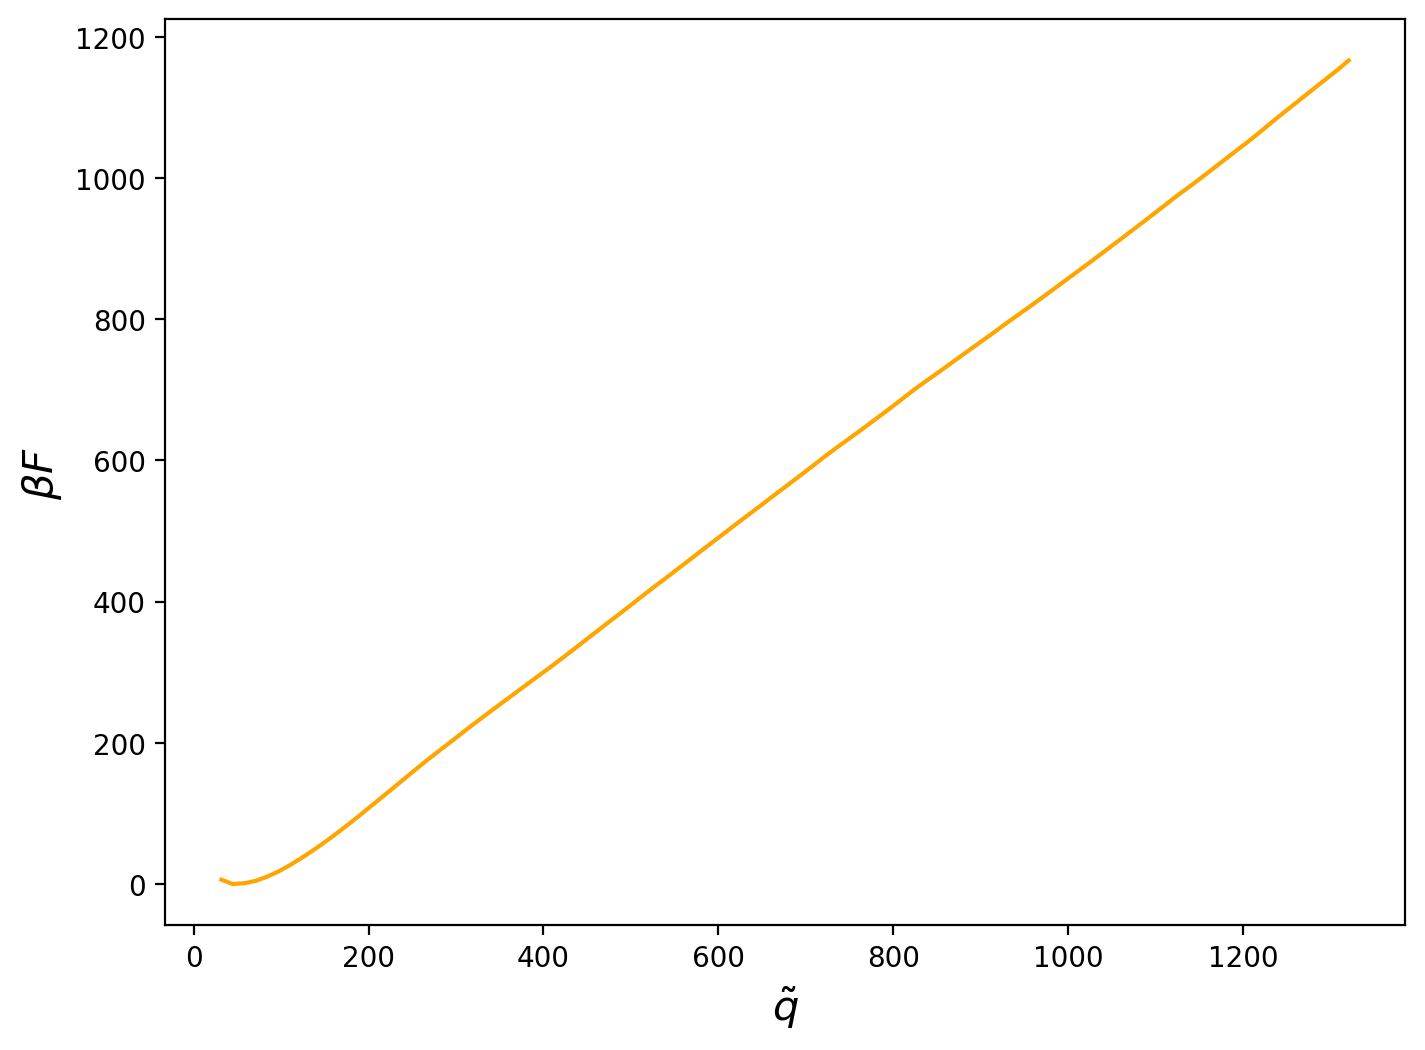

In [31]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=200)


plt.plot(bins_,F, color='orange')

plt.xlabel(r'$\tilde{q}$', fontsize=15)
plt.ylabel(r'$\beta F$', fontsize=15)

In [65]:
aq[:x]

array([ 52.86067913,  76.28573156, 111.28813961, 164.06315232])

In [66]:
bins_[:3*x]

array([ 31.68934   ,  44.71060626,  57.73187253,  70.75313879,
        83.77440505,  96.79567131, 109.81693758, 122.83820384,
       135.8594701 , 148.88073636, 161.90200263, 174.92326889])

In [70]:
free[2]

30.06900996716391

In [69]:
F[6]

26.648785807901504

Text(0.5, 1.0, 'T = Tm')

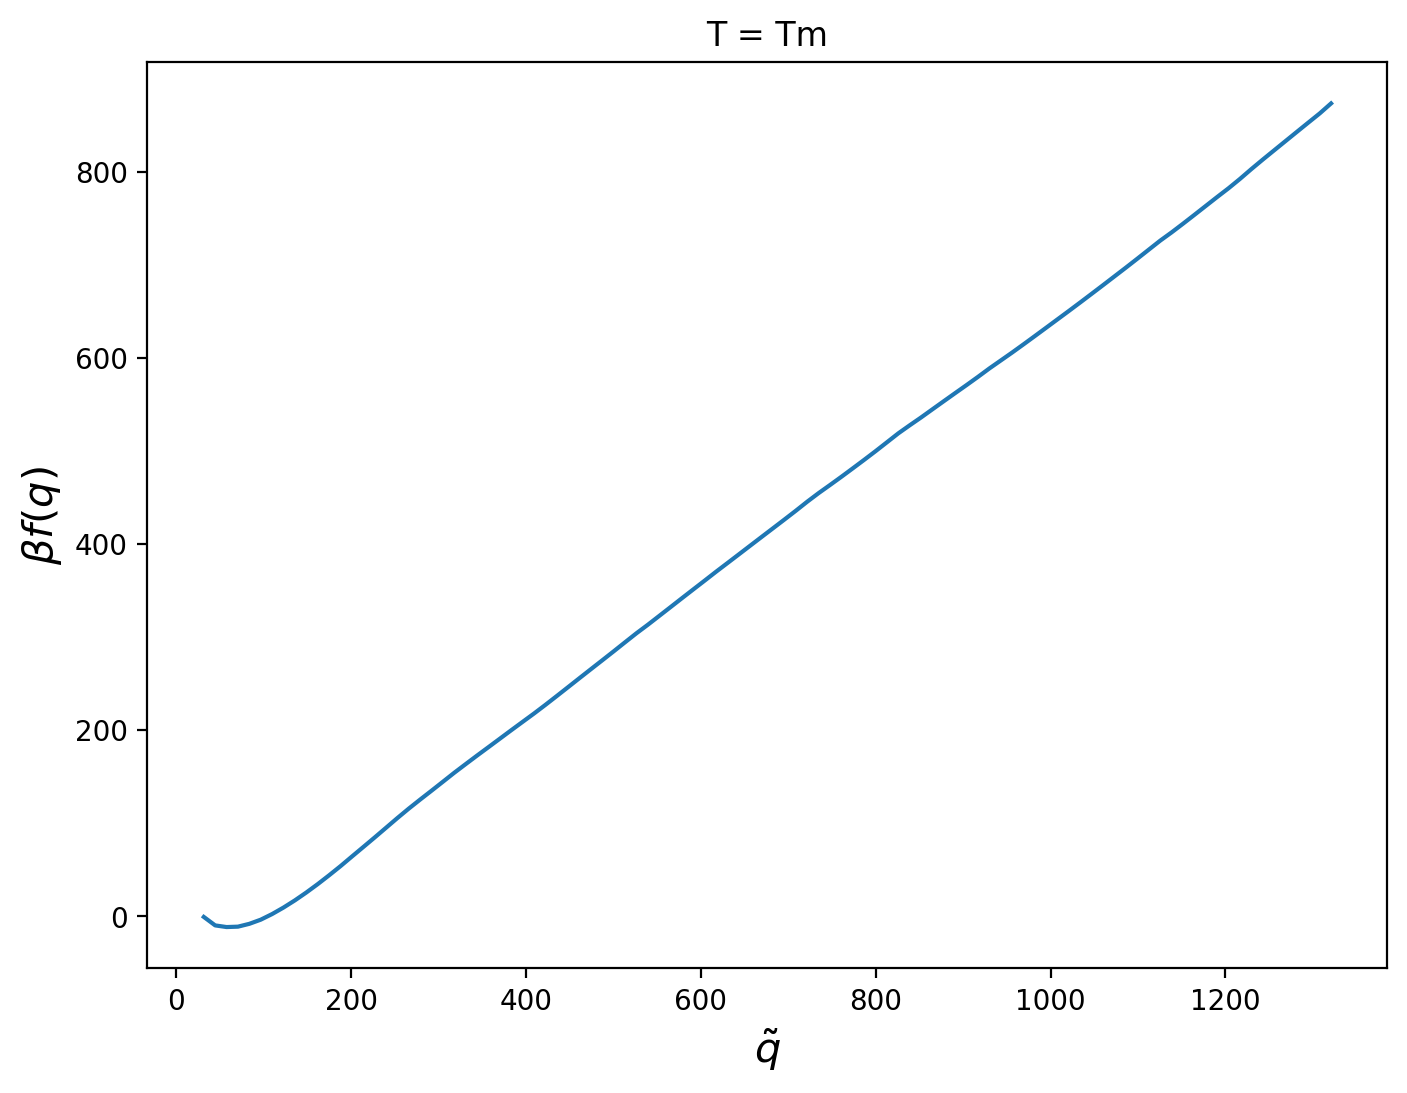

In [32]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=200)

F2 = F - 0.55*beta*bins_

x = -1

plt.plot(bins_,F2)

plt.xlabel(r'$\tilde{q}$', fontsize=15)
plt.ylabel(r'$\beta f(q)$', fontsize=15)
plt.title('T = Tm')

Text(0, 0.5, '$\\beta \\frac{\\partial f}{\\partial q}$')

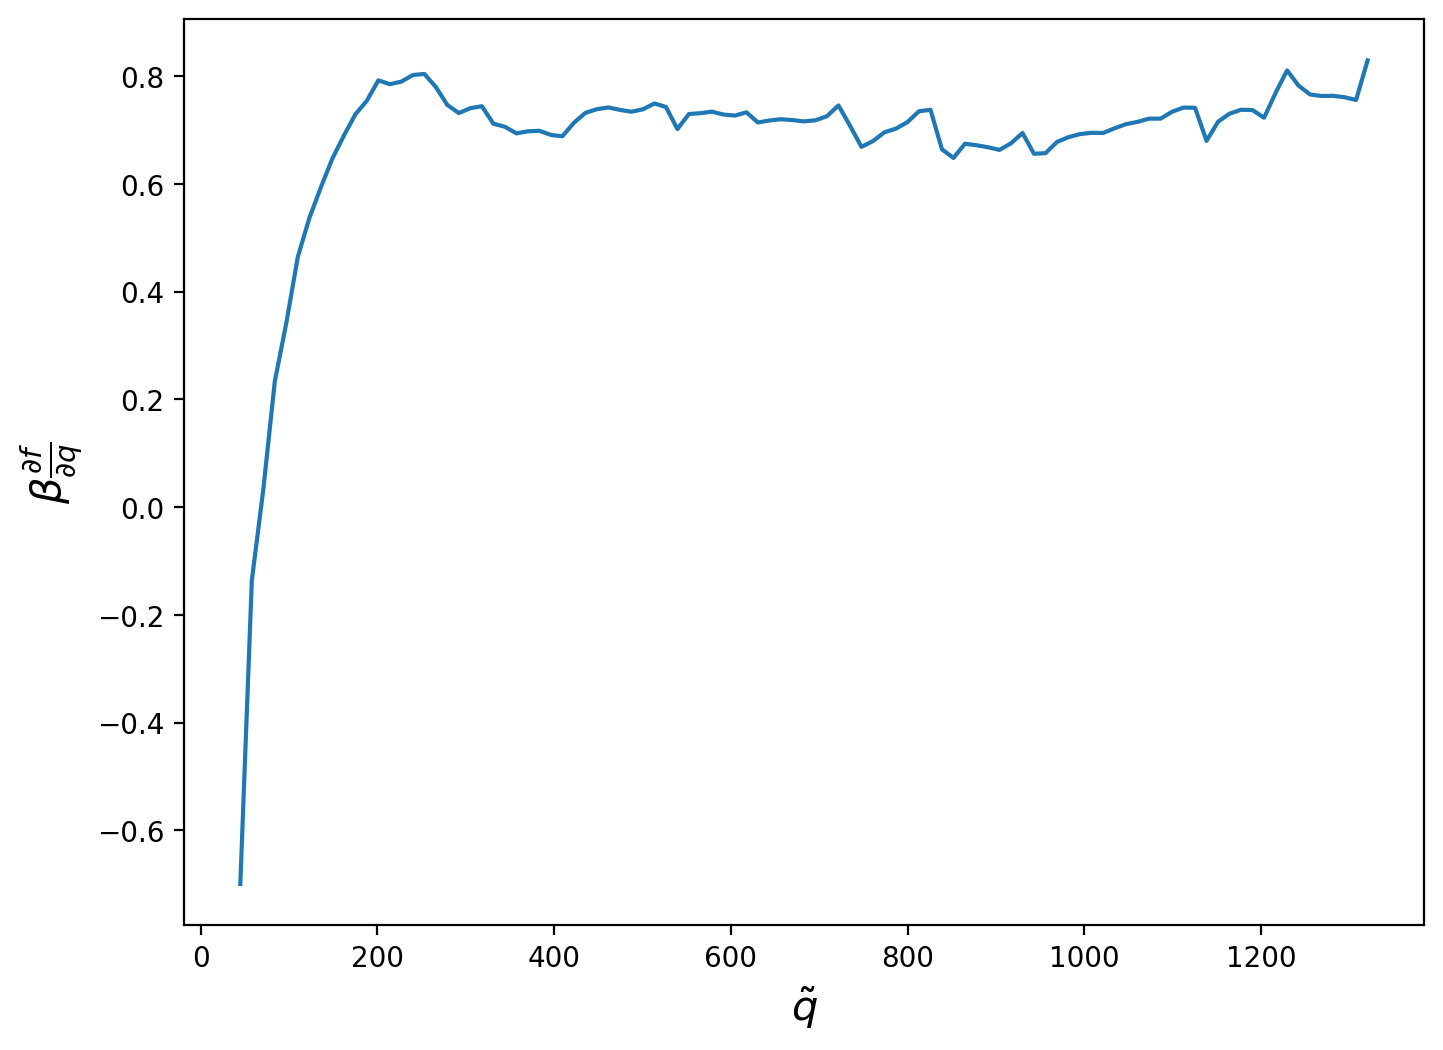

In [27]:
driving_force = np.zeros(len(F2)-1,)
for i in range(len(F2)-1):
    driving_force[i] = (F2[i+1] - F2[i])/(bins_[i+1]-bins_[i])

from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=200)


plt.plot(bins_[1:],driving_force)

plt.xlabel(r'$\tilde{q}$', fontsize=15)
plt.ylabel(r'$\beta \frac{\partial f}{\partial q}$', fontsize=15)

In [24]:
0.8/0.55*25

36.36363636363637

In [28]:
0.8*8.314*298/1000

1.9820576

In [29]:
1.98/0.55*25

89.99999999999999